In [1]:
import pandas as pd
import re
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline 

from collections import defaultdict
import statsmodels
from statsmodels.tsa.seasonal import STL

# Introduction
- this notebook cleans the Aadhar demographic dataset and outputs the cleaned, concatenated dataset

In [2]:
import os 
base_dir = r'/kaggle/input/aadhar-demographic-data-2025'
dfs = []
for files in os.listdir(base_dir):
    path = os.path.join(base_dir,files)
    dfs.append(pd.read_csv(path))
df = pd.concat([df for df in dfs],axis=0)
# del dfs
df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,19-09-2025,Maharashtra,Satara,415517,0,2
1,19-09-2025,Maharashtra,Satara,415518,0,2
2,19-09-2025,Maharashtra,Satara,415520,0,3
3,19-09-2025,Maharashtra,Satara,415539,1,5
4,19-09-2025,Maharashtra,Sindhudurg,416510,4,37


# Data Cleaning 

## States Cleaning
- normalizing the names (remove punctuations,spaces, unwanted characters,lowercase)
- then we make a minimal cannonical map to map unnormalized or fuzzy state names to actual names
- finally we create three columns and apply these functions sequentially

In [3]:
for idx,df in enumerate(dfs):
    print(f'DF-{idx}')
    print(f"States: {df['state'].unique()}")
    print(f"Count:{df['state'].nunique()}")

DF-0
States: ['Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland' 'ODISHA'
 'Odisha' 'Orissa' 'Pondicherry' 'Puducherry' 'Punjab' 'Rajasthan'
 'Tamil Nadu' 'Telangana' 'Tripura' 'Uttar Pradesh' 'Sikkim' 'Uttarakhand'
 'West  Bengal' 'West Bengal' 'Andaman & Nicobar Islands' 'odisha'
 'Andaman and Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Delhi' 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu & Kashmir'
 'Jammu and Kashmir' 'Jharkhand' 'Karnataka' 'Kerala' 'Lakshadweep'
 'Madhya Pradesh' 'Ladakh' 'Dadra and Nagar Haveli and Daman and Diu'
 'Daman and Diu' 'west Bengal' 'Daman & Diu' 'Dadra & Nagar Haveli'
 'West Bangal' 'Westbengal' 'andhra pradesh' 'WESTBENGAL' 'WEST BENGAL'
 'West bengal' 'West Bengli' 'BALANAGAR' 'Uttaranchal' '100000' 'Jaipur'
 'Madanapalle' 'Chhatisgarh']
Count:61
DF-1
States: ['Karnataka' 'Kerala' 'Ladakh' 'Madhya Pradesh' 'Maharashtra' 'Punjab'
 'Rajasthan' 'Sikkim' 'Tami

In [4]:
## Cleaning Pipeline
def normalize_state(s):
    if pd.isna(s):
        return np.nan

    s = str(s)

    ##encoding 
    s = unicodedata.normalize('NFKD',s)
    s = s.encode('ascii','ignore').decode('ascii')

    #string manipulation
    s = s.lower()
    s = s.replace('&','and')
    ## removing punctuations/spaces
    s = re.sub(r"[\(\)\[\]\.,:]"," ",s)
    s = s.replace('/'," ")
    s = re.sub(r"\s+"," ",s)
    s = s.strip()
    ##pure numbers
    if re.fullmatch(r"\d+",s):
        return np.nan
    return s


##minimal canonical map
STATE_MAP = {

    # ---------------- Simple aliases ----------------
    "odisha": "Odisha",
    "orissa": "Odisha",
    "uttaranchal": "uttarakhand",
    "pondicherry": "puducherry",
    "tamilnadu": "tamil nadu",
    "chhatisgarh": "chhattisgarh",
    "west bengal": "West Bengal",
    "westbengal": "West Bengal",
    "west bangal": "West Bengal",
    "west bengli": "West Bengal",

    # ---------------- Merged UT (FORCE CANONICAL) ----------------
    "dadra and nagar haveli": 
        "dadra and nagar haveli and daman and diu",

    "daman and diu": 
        "dadra and nagar haveli and daman and diu",

    "dadra and nagar haveli and daman and diu": 
        "dadra and nagar haveli and daman and diu",

    # ---------------- Symbol normalization ----------------
    "jammu and kashmir": "jammu and kashmir",
    "andaman and nicobar islands": "andaman and nicobar islands",
    "andhra pradesh": "andhra pradesh",
    "odisha": "odisha",
    "west bengal": "west bengal",
}
# Cities / garbage we want to discard
INVALID = {
    "jaipur", "nagpur", "balanagar", "madanapalle",
    "darbhanga", "puttenahalli", "raja annamalai puram",
    "100000"
}


def clean_state_column(df,col='state'):
    df = df.copy()
    
    df["_raw_state"] = df[col]
    df["_norm_state"] = df[col].apply(normalize_state)
    
    # mark invalid
    df.loc[df["_norm_state"].isin(INVALID), "_norm_state"] = np.nan
    
    # apply mapping
    df["state_clean"] = df["_norm_state"].map(
        lambda x: STATE_MAP.get(x, x.title()) if pd.notna(x) else np.nan
    )


    df["state_clean"] = df["state_clean"].replace("", np.nan)
    df = df.dropna(subset=["state_clean"])

    df['_mapped_state'] = df['_norm_state'].map(
        lambda x: STATE_MAP.get(x,x) if pd.notna(x) else np.nan
    )

    df['state_clean'] = (
        df['_mapped_state']
        .str.title()
        .str.replace(r'\s+'," ",regex=True)
        .str.strip()
    )

    return df

In [5]:
## applying the maps on the dataframes
state_cleaned_dfs = [clean_state_column(df) for df in dfs]

for idx,df in enumerate(state_cleaned_dfs):
    print(f'DF-{idx}')
    print(f"States: {df['state_clean'].unique()}")
    print(f"Count:{df['state_clean'].nunique()}")
    # display(df.head())

DF-0
States: ['Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha'
 'Puducherry' 'Punjab' 'Rajasthan' 'Tamil Nadu' 'Telangana' 'Tripura'
 'Uttar Pradesh' 'Sikkim' 'Uttarakhand' 'West Bengal'
 'Andaman And Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh'
 'Dadra And Nagar Haveli And Daman And Diu' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Himachal Pradesh' 'Jammu And Kashmir' 'Jharkhand' 'Karnataka'
 'Kerala' 'Lakshadweep' 'Madhya Pradesh' 'Ladakh']
Count:36
DF-1
States: ['Karnataka' 'Kerala' 'Ladakh' 'Madhya Pradesh' 'Maharashtra' 'Punjab'
 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana' 'Manipur' 'Meghalaya'
 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Jammu And Kashmir'
 'Jharkhand' 'Uttar Pradesh' 'Uttarakhand' 'West Bengal'
 'Andaman And Nicobar Islands' 'Andhra Pradesh' 'Assam' 'Bihar'
 'Chandigarh' 'Chhattisgarh' 'Dadra And Nagar Haveli And Daman And Diu'
 'Delhi' 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Arunachal Prades

- cleaned state + UT count should be 36 

## District Cleaning
- first we normalize names using unicode encoding and decoding, followed by simple string normalization like lowercase, no punctuations, no special characters, numbers
- further we matched some common garbage patterns
- mapped names and fuzzy names to new names
- applied all these functions sequentially
- THIS CLEANING DOESN'T GUARANTEE 100% PRODUCTION READY DATASET (THAT CAN ONLY BE ACHEIVED USING A CANONICAL MAP OF ALL THE DISTRICTS) 

In [6]:
for idx,df in enumerate(state_cleaned_dfs):
    print(f'Data Frame: {idx+1}')
    print(f'Count: {df["district"].nunique()}')
    # print(f'Districts:{df["district"].unique()}')

Data Frame: 1
Count: 961
Data Frame: 2
Count: 961
Data Frame: 3
Count: 954
Data Frame: 4
Count: 924
Data Frame: 5
Count: 958


In [7]:
##district cleaning pipeline

def normalize_district(s):
    if pd.isna(s):
        return np.nan

    s = str(s)

    s = unicodedata.normalize("NFKD", s)
    s = s.encode('ascii','ignore').decode('ascii')

    s = s.lower()
    s = s.replace('&','and')
    s = s.replace("−", "-").replace("–", "-").replace("—", "-")

    s = re.sub(r"[\(\)\[\]\{\}]", " ", s)
    s = re.sub(r"[^\w\s\-]", " ", s)

    # Remove admin suffixes
    s = re.sub(r"\b(district|dist|distt|dist :)\b", "", s)

    # Remove stray symbols
    s = re.sub(r"[*]", "", s)

    for k, v in NUMBER_WORDS.items():
        s = re.sub(rf"\b{k}\b", v, s)

    s = re.sub(r"\b20\s+4\b", "24", s)

    s = re.sub(r"\s+", " ", s).strip()

    if re.fullmatch(r'\d+', s):
        return np.nan

    return s


##allowed directions
DIRECTION_ONLY = {
        "north", "south", "east", "west",
    "north east", "north west", "south east", "south west"
}

##sub localities
GARBAGE_PATTERNS = [
    r"\bnear\b",
    r"\broad\b",
    r"\bcolony\b",
    r"\bcross\b",
    r"\bthana\b",
    r"\bsector\b",
    r"\bward\b",
    r"\bblock\b",
]


EXPLICIT_GARBAGE = {
    "domjur",
    "bardez",
    "tiswadi",
    "najafgarh",
    "bally jagachha",
    "south dumdum m",
}


def is_garbage(s):
    if s is None or pd.isna(s):
        return True

    s = s.strip()

    if len(s) <= 2:
        return True

    if s in DIRECTION_ONLY:
        return True

    if s in EXPLICIT_GARBAGE:
        return True


    for pat in GARBAGE_PATTERNS:
        if re.search(pat,s):
            return True

    return False


NUMBER_WORDS = {
    "one": "1", "two": "2", "three": "3", "four": "4",
    "five": "5", "six": "6", "seven": "7", "eight": "8",
    "nine": "9", "ten": "10", "twenty": "20",
}

#minimal cannonical map
CANONICAL_MAP = {
    
    "bara banki": "barabanki",
    "raebareli": "rae bareli",
    "purbi singhbhum": "east singhbhum",
    "paschim singhbhum": "west singhbhum",
    "jaipur rural": "jaipur",
    "jodhpur rural": "jodhpur",
    "bikaner rural": "bikaner",
    "bagalkot": "bagalkote",
    "bijapur kar": "vijayapura",
    "dharwad": "dharwad",
    "kalaburagi": "kalaburagi",
    "gulbarga": "kalaburagi",
    "trichy": "tiruchirappalli",
    "thoothukudi": "thoothukkudi",
    "vizag": "visakhapatnam",
    "ysr kadapa": "kadapa",
    "cuddapah": "kadapa",
    "indore rural": "indore",
    "bhopal rural": "bhopal",

    

    # ---- spelling duplicates ----
    "viluppuram": "villupuram",
    "rangareddi": "rangareddy",
    "buldana": "buldhana",
    "hazaribag": "hazaribagh",
    "malda": "maldah",
    "puruliya": "purulia",
    "jhunjhunun": "jhunjhunu",
    "khorda": "khordha",

    # ---- Andhra normalization ----
    "ananthapur": "ananthapuramu",
    "anantapur": "ananthapuramu",

    #------ Karnataka-----
    # 'Chickmagalur':'Chikmagalur',
    "chikkaballapur":"chikmagalur",
    "chikkamagaluru":"chikmagalur",
    "chikmagalur":"chikmagalur",


    # ---- Numeric normalization ----
    "north 24 parganas": "north 24 parganas",
    "north twenty four parganas": "north 24 parganas",
    "south 24 parganas": "south 24 parganas",
    "south twenty four parganas": "south 24 parganas",

    # ---- Renamed districts ----
    "allahabad": "prayagraj",
    "aurangabad bh": "chhatrapati sambhajinagar",
    "osmanabad": "dharashiv",

    # ---- Merged UT ----
    "diu": "dadra and nagar haveli and daman and diu",
    "dadra and nagar haveli": "dadra and nagar haveli and daman and diu",
    "daman and diu": "dadra and nagar haveli and daman and diu",
}

CANONICAL_MAP.update({
    # West Bengal
    "barddhaman": "purba bardhaman",
    "burdwan": "purba bardhaman",

    # Mumbai variants
    "mumbai suburban": "mumbai suburban",
    "mumbai sub urban": "mumbai suburban",
    "mumbai city": "mumbai city",

    # Rural/Urban collapses
    "warangal rural": "warangal",
    "warangal urban": "warangal",
    "bangalore rural": "bengaluru",
    "bengaluru rural": "bengaluru",

    # Assam metro
    "kamrup metro": "kamrup metropolitan",

    # Assam new district
    "tamulpur district": "tamulpur",
    "tamulpur": "tamulpur",

    # Road-based
    "kadiri road": "kadiri",
    
    # ---- West Bengal ----
    "hugli": "hooghly",
    "hooghiy": "hooghly",
    "haora": "howrah",
    "medinipur": "paschim medinipur",

    # ---- Odisha ----
    "baleswar": "baleshwar",
    "sonapur": "subarnapur",

    # ---- Maharashtra ----
    "ahmadnagar": "ahilyanagar",
    "ahmednagar": "ahilyanagar",
    "chatrapati sambhaji nagar": "chhatrapati sambhajinagar",
    "raigarh mh": "raigarh",

    # ---- Tamil Nadu ----
    "kanyakumari": "kanniyakumari",
    "thiruvarur": "tiruvarur",
    "tuticorin": "thoothukkudi",
    "tirupathur": "tirupattur",

    # ---- Telangana ----
    "k v rangareddy": "rangareddy",

    # ---- Assam ----
    "north cachar hills": "dima hasao",

    # ---- Garbage collapses ----
    "andamans": np.nan,
    "nicobars": np.nan,
    "leh ladakh": "leh",
    "bijapur kar": "bijapur",
    "mammit": "mamit",
})


def make_key(s):
    if pd.isna(s):
        return np.nan

    s = s.lower()

    s = re.sub(r"[\s\-]", "", s)
    s = re.sub(r"[aeiou]","",s)
    return s


def clean_district_column(df, col="district"):
    df = df.copy()

    df["_raw"] = df[col]

    # normalize
    df["_norm"] = df[col].apply(normalize_district)

    # garbage removal
    df.loc[df["_norm"].apply(is_garbage), "_norm"] = np.nan

    # canonical mapping
    df["_canon"] = df["_norm"].map(
        lambda x: CANONICAL_MAP.get(x, x) if pd.notna(x) else np.nan
    )

    # build grouping key
    df["_key"] = df["_canon"].apply(make_key)

    # auto-collapse by dominant spelling
    key_to_canon = {}

    valid = df.dropna(subset=["_canon", "_key"])

    for key, grp in valid.groupby("_key"):
        canonical = grp["_canon"].value_counts().idxmax()
        key_to_canon[key] = canonical

    df["district_clean"] = df["_key"].map(key_to_canon)

    # formatting
    df["district_clean"] = (
        df["district_clean"]
        .str.replace("-", " ", regex=False)
        .str.title()
        .str.replace(" And ", " and ", regex=False)
        .str.strip()
    )

    return df

In [8]:
cleaned_df = [clean_district_column(df) for df in state_cleaned_dfs]

for idx,df in enumerate(cleaned_df):
    print(f"df: {idx+1}")
    print(f'COUNT: {df["district_clean"].nunique()}')

df: 1
COUNT: 797
df: 2
COUNT: 796
df: 3
COUNT: 795
df: 4
COUNT: 787
df: 5
COUNT: 795


## Verifying cleaned states and districts

In [9]:
df = pd.concat([df[['date','state_clean','district_clean','pincode','demo_age_5_17','demo_age_17_']] for df in cleaned_df],axis=0).reset_index()
df.shape

(2071687, 7)

In [10]:
df.head()

,index,date,state_clean,district_clean,pincode,demo_age_5_17,demo_age_17_
0,0,19-09-2025,Maharashtra,Satara,415517,0,2
1,1,19-09-2025,Maharashtra,Satara,415518,0,2
2,2,19-09-2025,Maharashtra,Satara,415520,0,3
3,3,19-09-2025,Maharashtra,Satara,415539,1,5
4,4,19-09-2025,Maharashtra,Sindhudurg,416510,4,37


In [11]:
df.state_clean.nunique()

36

In [12]:
df.district_clean.nunique()

804

In [13]:
df.to_csv('cleaned_data.csv',index=False)

In [14]:
df.isnull().sum()

index                0
date                 0
state_clean          0
district_clean    2265
pincode              0
demo_age_5_17        0
demo_age_17_         0
dtype: int64

In [15]:
df.duplicated().sum()


np.int64(0)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071687 entries, 0 to 2071686
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   index           int64 
 1   date            object
 2   state_clean     object
 3   district_clean  object
 4   pincode         int64 
 5   demo_age_5_17   int64 
 6   demo_age_17_    int64 
dtypes: int64(4), object(3)
memory usage: 110.6+ MB


### Data preparation
- index column is redundant
- date column should be datetime index not string
- drop all the duplicates
- make day, month, year type of features

In [17]:
df_copy = df.copy()

df_copy = df_copy.drop(columns=['index'])

df_copy = df_copy.dropna(axis=0)


In [18]:
df_copy['date'] = pd.to_datetime(df_copy['date'],dayfirst=True)

df_copy['day'] = df_copy['date'].dt.day
df_copy['month'] = df_copy['date'].dt.month
df_copy['year'] = df_copy['date'].dt.year
df_copy['dayname'] = df_copy['date'].dt.day_name()
df_copy['dayofweek'] = df_copy['date'].dt.dayofweek
df_copy['quarter'] = df_copy['date'].dt.quarter

df_copy = df_copy.sort_values(by=['date','state_clean','district_clean','pincode'])
df_copy['pincode'] = df_copy['pincode'].apply(str)
df_copy.head()

,date,state_clean,district_clean,pincode,demo_age_5_17,demo_age_17_,day,month,year,dayname,dayofweek,quarter
331434,2025-03-01,Andaman And Nicobar Islands,Nicobar,744301,16,180,1,3,2025,Saturday,5,1
658903,2025-03-01,Andaman And Nicobar Islands,Nicobar,744301,16,180,1,3,2025,Saturday,5,1
1418043,2025-03-01,Andaman And Nicobar Islands,North and Middle Andaman,744202,10,201,1,3,2025,Saturday,5,1
1817212,2025-03-01,Andaman And Nicobar Islands,North and Middle Andaman,744202,10,201,1,3,2025,Saturday,5,1
329810,2025-03-01,Andaman And Nicobar Islands,South Andaman,744101,13,76,1,3,2025,Saturday,5,1


# Insight Methodology - Spatio Temporal Analysis
1. Which states/districts/pincodes consistently generate the highest biometric volumne ?
2. How does activity vary by Day-of-week, Month/Quarter , School Calendar ?
3. Do activity spikes at month end ?
4. Under-served and Over-served districts
5. Age group behaviour, histograms , youth_ratio
6. Anomaly Detection - IQR, Rolling IQR or Isolation Forest
7. Forecasting(maybe)

## Feature generation

In [19]:
df_copy['total_demo'] = df_copy['demo_age_5_17'] + df_copy['demo_age_17_']
df_copy['youth_ratio'] = df_copy['demo_age_5_17']/(df_copy['total_demo']+1)
df_copy['year_month'] = df_copy['date'].dt.to_period('M').astype(str)
df_copy['is_weekend'] = df_copy['dayofweek'].isin([5,6]).astype(int)

# EDA

## 1. National Average per month

Text(0, 0.5, 'Total Demo')

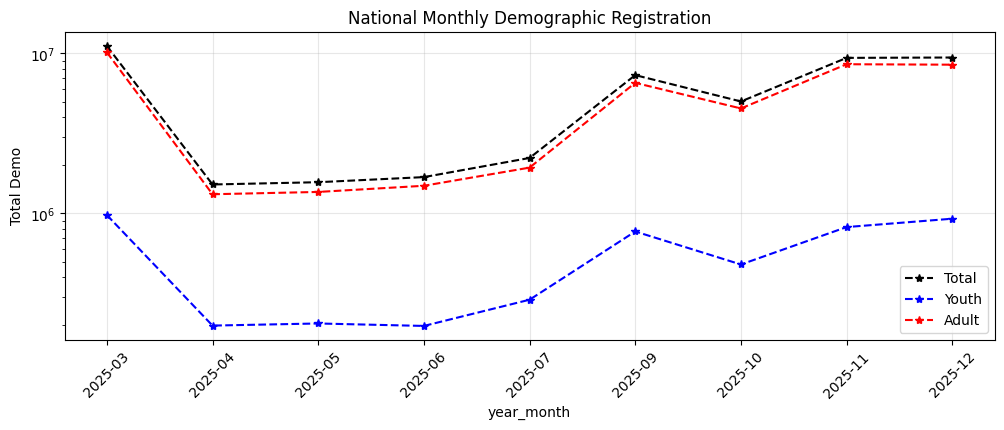

In [20]:
fig,ax = plt.subplots(figsize=(12,4))
monthly = df_copy.groupby(['year_month'])['total_demo'].sum()
monthly_youth = df_copy.groupby(['year_month'])['demo_age_5_17'].sum()
monthly_adult = df_copy.groupby(['year_month'])['demo_age_17_'].sum()
monthly.plot(title='National Monthly Demographic Registration',marker='*',linestyle='--',color='black',ax=ax,label='Total')
monthly_youth.plot(marker='*',linestyle='--',color='blue',ax=ax,label='Youth')
monthly_adult.plot(marker='*',linestyle='--',color='red',ax=ax,label='Adult')
ax.grid(alpha=0.3)
ax.legend()
ax.set_yscale('log')
ax.tick_params('x',rotation=45)
ax.set_ylabel('Total Demo')

### March 2025 shows the highest activity
   - Total Aadhaar updates peak in March, driven mainly by adult updates.
   - Likely due to financial-year-end, administrative updates, and address changes.

## 2. Weekday demand pattern

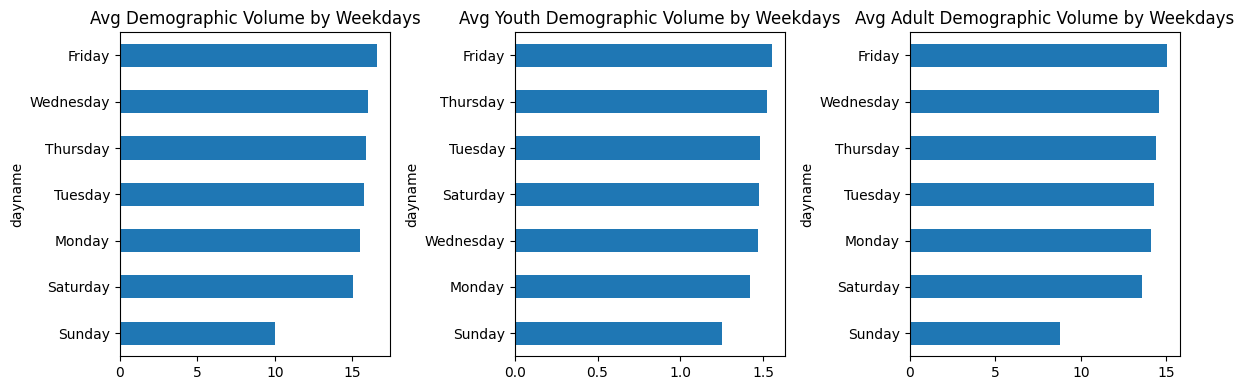

In [21]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
day_wise_data = df_copy[df_copy.month >= 9]

weekday = day_wise_data.groupby('dayname')['total_demo'].mean().sort_values()
weekday_youth = day_wise_data.groupby('dayname')['demo_age_5_17'].mean().sort_values()
weekday_adult = day_wise_data.groupby('dayname')['demo_age_17_'].mean().sort_values()
weekday.plot(kind='barh',title='Avg Demographic Volume by Weekdays',ax=ax[0])
weekday_youth.plot(kind='barh',title='Avg Youth Demographic Volume by Weekdays',ax=ax[1])
weekday_adult.plot(kind='barh',title='Avg Adult Demographic Volume by Weekdays',ax=ax[2])
#[ax[i].grid(alpha=0.1) for i in range(3)]

plt.tight_layout()

## 3. Top regions by Demographic Volume

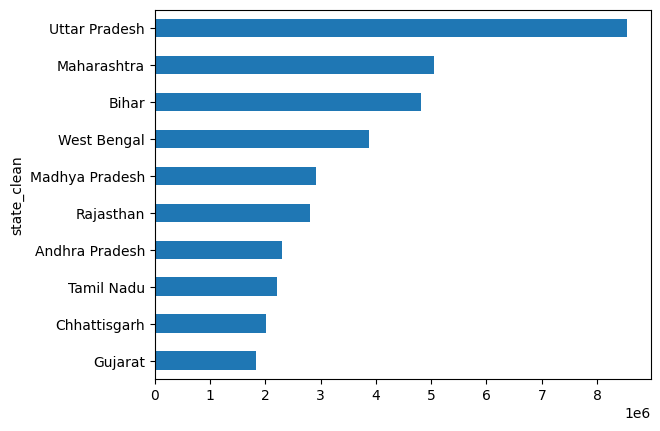

In [22]:
k = 10
top_states = (
    df_copy.groupby('state_clean')['total_demo']
    .sum()
    .sort_values(ascending=False)
    .head(k)
)

top_states.plot(kind='barh')
plt.gca().invert_yaxis()

## 4. Youth Behaviour

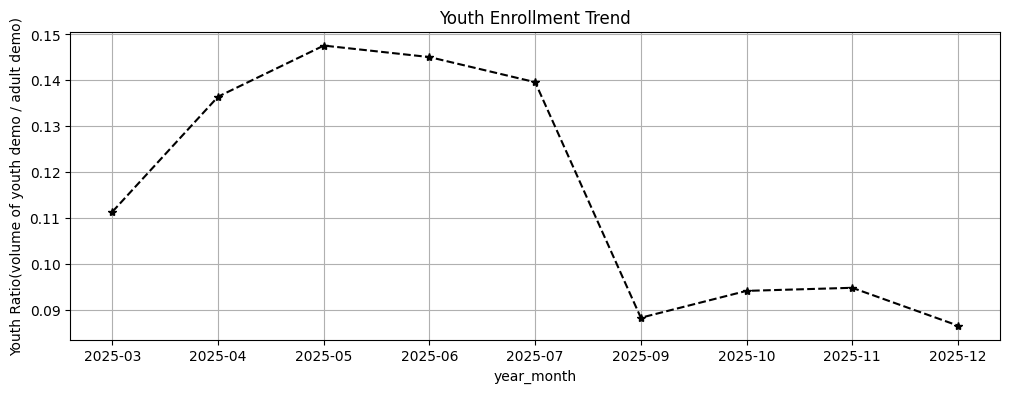

In [23]:
plt.figure(figsize=(12,4))
youth_trend = df_copy.groupby('year_month')['youth_ratio'].mean()
youth_trend.plot(kind='line',linestyle='--',color='black',marker='*',title='Youth Enrollment Trend')
plt.ylabel('Youth Ratio(volume of youth demo / adult demo)')
plt.grid()

## 5. District with unstable demand (Adv Viz - 01)

Text(0.5, 1.0, '15 Most Volatile Districts')

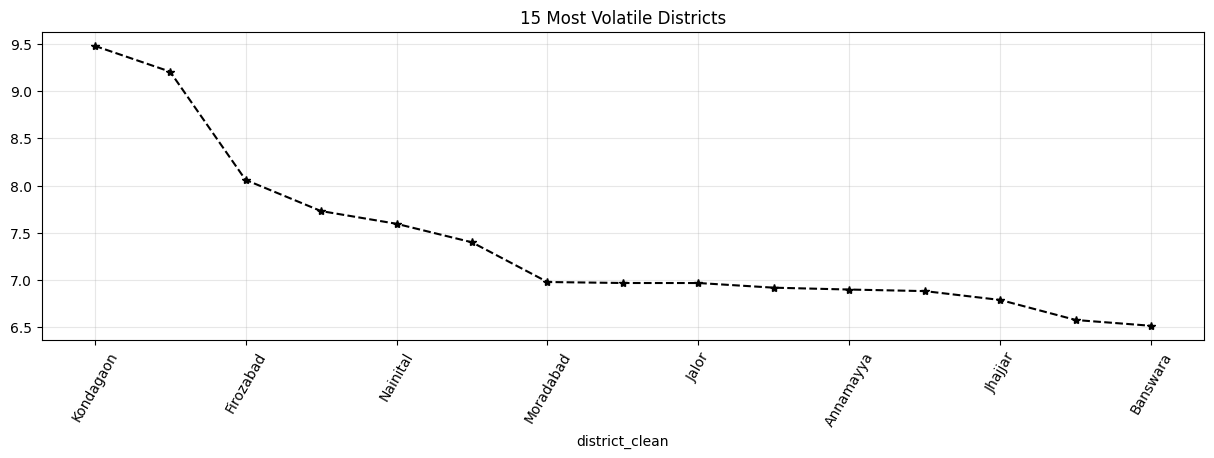

In [24]:
top_k=15

district_stats = (
    df_copy.groupby('district_clean')['total_demo']
    .agg(['std','mean'])
)

district_stats['volatility'] = district_stats['std'] / (district_stats['mean'] + 1)

fig,ax = plt.subplots(figsize=(15,4))
district_stats['volatility'].sort_values(ascending=False).head(top_k).plot(kind='line',ax=ax,marker='*',linestyle='--',color='black',linewidth=1.5)
ax.grid(alpha=0.3)
ax.tick_params('x',rotation=60)
ax.set_title(f'{top_k} Most Volatile Districts')

In [25]:
volatile_sorted = district_stats['volatility'].sort_values(ascending=False)

for i, d in enumerate(volatile_sorted.index, 1):
    print(f"{i}. {d}")


1. Kondagaon
2. Amritsar
3. Firozabad
4. Tirupati
5. Nainital
6. Panipat
7. Moradabad
8. Gandhinagar
9. Jalor
10. Raigad
11. Annamayya
12. Bokaro
13. Jhajjar
14. Aligarh
15. Banswara
16. Shimla
17. Dhanbad
18. Surat
19. Pauri Garhwal
20. Dehradun
21. Mahasamund
22. Hoshiarpur
23. Sas Nagar Mohali
24. Ajmer
25. Ludhiana
26. Kachchh
27. Patiala
28. Durg
29. Bilaspur
30. Koriya
31. Chittorgarh
32. Malerkotla
33. Baran
34. Lunglei
35. Gurgaon
36. Jaisalmer
37. Rajkot
38. Rajsamand
39. Sonipat
40. Alwar
41. Deoghar
42. Saharanpur
43. Bulandshahr
44. Pakur
45. Pali
46. Y S R
47. Dungarpur
48. Gautam Buddha Nagar
49. Palnadu
50. Rohtak
51. Bikaner
52. Ramgarh
53. West Delhi
54. Chhatrapati Sambhajinagar
55. Hazaribagh
56. Ballari
57. South Delhi
58. Rewari
59. Nandyal
60. Jhalawar
61. Sri Potti Sriramulu Nellore
62. Gurdaspur
63. Ferozepur
64. Hapur
65. Barmer
66. Shahjahanpur
67. Sangareddy
68. Dewas
69. Bhilwara
70. South West Delhi
71. Ganganagar
72. Giridih
73. Katni
74. Nagaur
75. Jodhpu

In [26]:
df_copy['district_clean'] = df_copy['district_clean'].replace({
    'Allahabad': 'Prayagraj',
    'Faizabad': 'Ayodhya'
})


In [27]:
df_copy[df_copy['district_clean'].isin(['Prayagraj', 'Ayodhya'])] \
  .groupby('district_clean')['total_demo'] \
  .sum()


district_clean
Ayodhya       85256
Prayagraj    215322
Name: total_demo, dtype: int64

In [28]:
top10_districts = (
    df_copy.groupby('district_clean')['total_demo']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

top10_districts


district_clean
Thane                486030
South 24 Parganas    443271
Pune                 438478
Bengaluru            404079
Murshidabad          371953
Surat                357582
North West Delhi     313989
North 24 Parganas    310212
Ahmedabad            275644
Jaipur               275340
Name: total_demo, dtype: int64

## 6. STL Decomposition of the Time Series - Identifying the core components of a time series

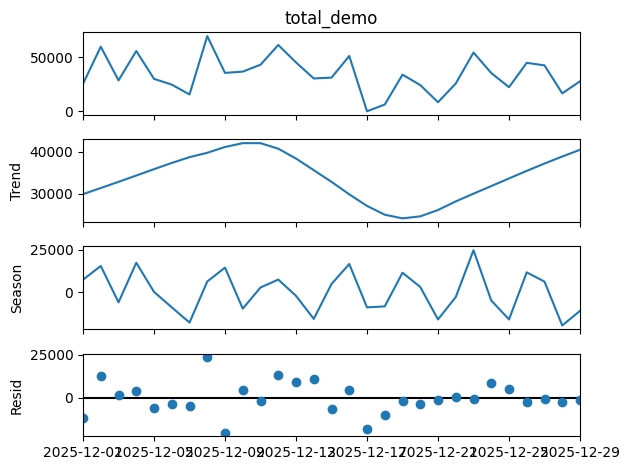

In [29]:
# Filter for Bihar and December
used_data = df_copy[
    (df_copy.month == 12) & 
    (df_copy.state_clean == "Bihar")
]

# Bihar daily time series
ts_bihar = (
    used_data.groupby('date')['total_demo']
      .sum()
      .asfreq('D')
      .fillna(0)
)
stl = STL(ts_bihar, period=7)
res = stl.fit()
res.plot();


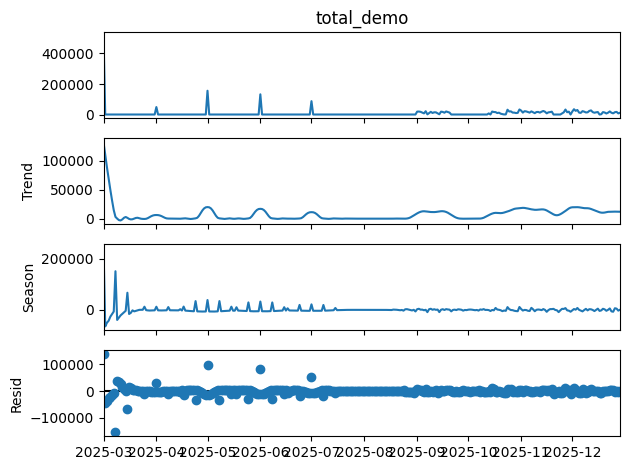

In [30]:
state = df_copy['state_clean'].value_counts().idxmax()

ts_state = (
    df_copy[df_copy['state_clean'] == state]
      .groupby('date')['total_demo']
      .sum()
      .asfreq('D')
      .fillna(0)
)

STL(ts_state, period=7).fit().plot();


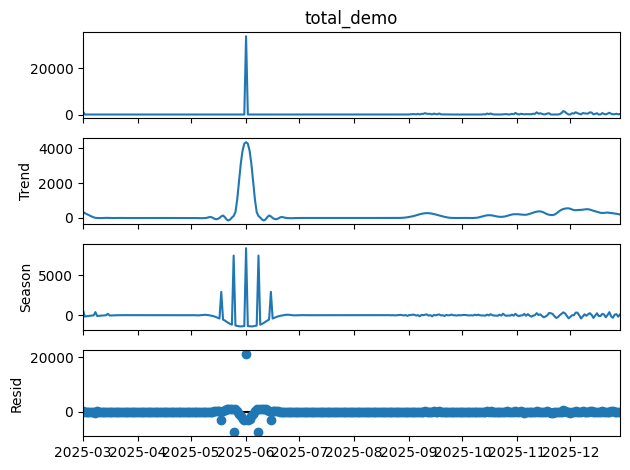

In [31]:
# Pick one from your volatility ranking
volatile_district = district_stats['volatility'].idxmax()

ts_district = (
    df_copy[df_copy['district_clean'] == volatile_district]
      .groupby('date')['total_demo']
      .sum()
      .asfreq('D')
      .fillna(0)
)

STL(ts_district, period=7).fit().plot();


In [32]:
district_stats['cv'] = district_stats['std'] / (district_stats['mean'] + 1)


district_stats['efficiency'] = district_stats['mean'] / (district_stats['cv'] + 1)


# 7. Spatial Stability & Risk Profiling

- identifying metrics that can segment areas to give relevant information like Infrastructure, Access, risk and under utilized zones when these metrics are treated as proxy indicators
- using KMeans cluster them
- t-SNE to plot them

In [33]:
g = df_copy.groupby(['state_clean','district_clean','year_month'])['total_demo'].sum().reset_index()

stats = (
    g.groupby(['state_clean','district_clean'])['total_demo']
    .agg(['mean','std','min','max'])
)

stats['volatility'] = stats['std']/(stats['mean']+1)

stats['range_ratio'] = (stats['max']-stats['min']) / (stats['mean']+1)

stats.head()

mean  \
state_clean                 district_clean                          
Andaman And Nicobar Islands Nicobar                    157.400000   
                            North and Middle Andaman   334.833333   
                            South Andaman              739.200000   
Andhra Pradesh              Adilabad                  5858.200000   
                            Alluri Sitharama Raju     2145.166667   

                                                              std   min   max  \
state_clean                 district_clean                                      
Andaman And Nicobar Islands Nicobar                    135.828200    59   392   
                            North and Middle Andaman   118.658193   149   438   
                            South Andaman              408.456485   398  1371   
Andhra Pradesh              Adilabad                  1314.437789  4340  7291   
                            Alluri Sitharama Raju     1584.877461   167  4955   

                                                      volatility  range_ratio  
state_clean                 district_clean                                     
Andaman And Nicobar Islands Nicobar                     0.857501     2.102273  
                            North and Middle Andaman    0.353325     0.860546  
                            South Andaman               0.551819     1.314510  
Andhra Pradesh              Adilabad                    0.224337     0.503652  
                            Alluri Sitharama Raju       0.738469     2.230954

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,DBSCAN

X = stats[['mean','volatility','range_ratio']].fillna(0)

X_scaled = StandardScaler().fit_transform(X)

stats['cluster_kmeans'] = KMeans(n_clusters=4,random_state=42).fit_predict(X_scaled)
stats['cluster_dbscan'] = DBSCAN(n_jobs=-1).fit_predict(X_scaled)

stats.head()


# stats_scaled = pd.DataFrame(np.concatenate((X_scaled,stats['cluster'].values)),columns=[f'col_{idx+1}' for idx in range(X.shape[1]+1)])


mean  \
state_clean                 district_clean                          
Andaman And Nicobar Islands Nicobar                    157.400000   
                            North and Middle Andaman   334.833333   
                            South Andaman              739.200000   
Andhra Pradesh              Adilabad                  5858.200000   
                            Alluri Sitharama Raju     2145.166667   

                                                              std   min   max  \
state_clean                 district_clean                                      
Andaman And Nicobar Islands Nicobar                    135.828200    59   392   
                            North and Middle Andaman   118.658193   149   438   
                            South Andaman              408.456485   398  1371   
Andhra Pradesh              Adilabad                  1314.437789  4340  7291   
                            Alluri Sitharama Raju     1584.877461   167  4955   

                                                      volatility  range_ratio  \
state_clean                 district_clean                                      
Andaman And Nicobar Islands Nicobar                     0.857501     2.102273   
                            North and Middle Andaman    0.353325     0.860546   
                            South Andaman               0.551819     1.314510   
Andhra Pradesh              Adilabad                    0.224337     0.503652   
                            Alluri Sitharama Raju       0.738469     2.230954   

                                                      cluster_kmeans  \
state_clean                 district_clean                             
Andaman And Nicobar Islands Nicobar                                3   
                            North and Middle Andaman               2   
                            South Andaman                          3   
Andhra Pradesh              Adilabad                               2   
                            Alluri Sitharama Raju                  3   

                                                      cluster_dbscan  
state_clean                 district_clean                            
Andaman And Nicobar Islands Nicobar                                0  
                            North and Middle Andaman               0  
                            South Andaman                          0  
Andhra Pradesh              Adilabad                               0  
                            Alluri Sitharama Raju                  0

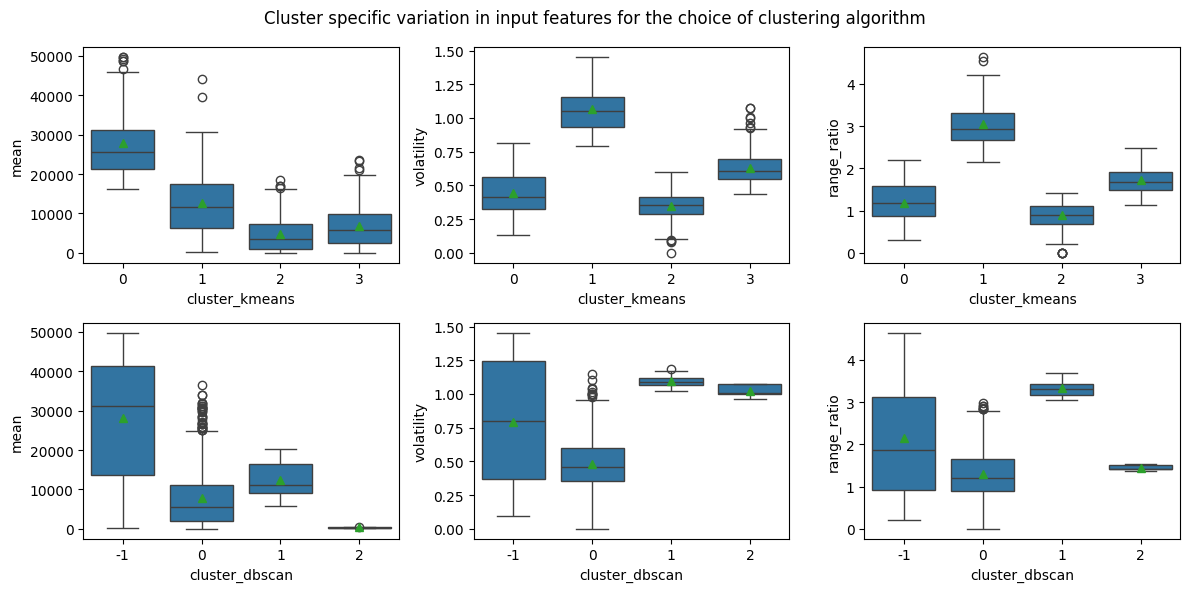

In [35]:
import seaborn as sns

fig,ax = plt.subplots(2,3,figsize=(12,6))
fig.suptitle('Cluster specific variation in input features for the choice of clustering algorithm')
# for idx,cols in enumerate(['mean','volatility','range_ratio']):
#     sns.boxplot(
#         data=stats,
#         y = cols,
#         x = stats['cluster'],
#         ax=ax[idx]
#     )

get_cols = ['mean','volatility','range_ratio']

for j in range(3):
    sns.boxplot(
        data=stats,
        y = get_cols[j],
        x = stats['cluster_kmeans'],
        showmeans=True,
        ax = ax[0,j]
    )
    sns.boxplot(
        data=stats,
        y = get_cols[j],
        x = stats['cluster_dbscan'],
        showmeans=True,
        ax = ax[1,j]
    )


plt.tight_layout()

In [36]:
## from the above graph, it's clear that the Kmeans cluster are more organized and convey information more clearly,
## we'll map them for labelling them in graph

CLUSTER_NAMES = {
    0:'Stable Mid-Demand',
    1:'High Capacity Region',
    2:'Volatile',
    3:'Under utilized stable'
}

CLUSTER_COLORS = {
    0:'tab:blue',
    1:'tab:green',
    2:'tab:red',
    3:'tab:purple'
}

In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

INPUT = stats.fillna(0)

INPUT_scaled = StandardScaler().fit_transform(INPUT[['mean','volatility','range_ratio']])

tsne = TSNE().fit_transform(INPUT_scaled)
pca = PCA(n_components=2).fit_transform(INPUT_scaled)



# plt.subplot(2,2,3)
# plt.scatter(tsne[:,0],tsne[:,1],c=INPUT['cluster_dbscan'],cmap='viridis')
# plt.grid(alpha=.3)
# plt.title('t-SNE Cluster Representation - DBSCAN')

# plt.subplot(2,2,4)
# plt.scatter(pca[:,0],pca[:,1],c=INPUT['cluster_dbscan'],cmap='viridis')
# plt.grid(alpha=.3)
# plt.title('PCA Cluster Representation - DBSCAN')


plt.tight_layout()

<Figure size 640x480 with 0 Axes>

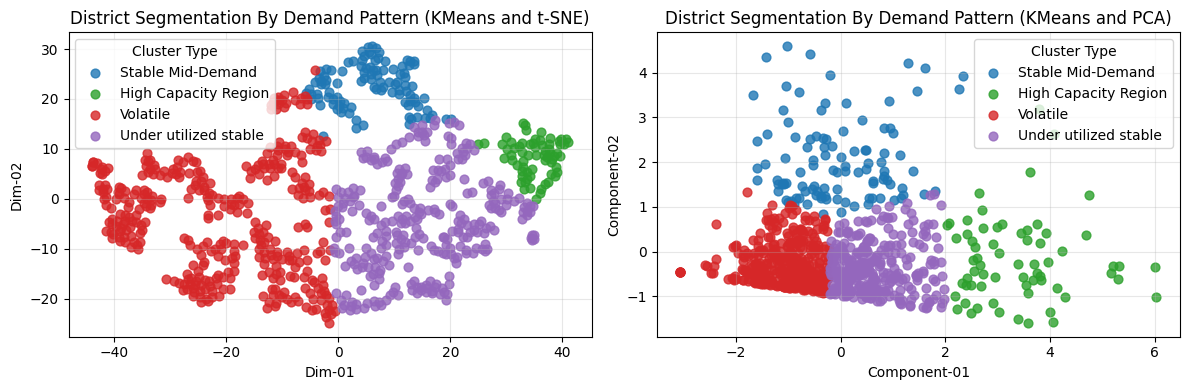

In [38]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

labels = INPUT['cluster_kmeans'].values

for c in sorted(set(labels)):
    mask = (labels==c)
    ax[0].scatter(
        tsne[mask,0],
        tsne[mask,1],
        s=40,
        alpha=0.8,
        c = CLUSTER_COLORS[c],
        label=CLUSTER_NAMES[c]
    )

    ax[1].scatter(
            pca[mask,0],
            pca[mask,1],
            s=40,
            alpha=0.8,
            c = CLUSTER_COLORS[c],
            label=CLUSTER_NAMES[c]
        )

ax[0].set_title('District Segmentation By Demand Pattern (KMeans and t-SNE)')
ax[0].set_xlabel('Dim-01')
ax[0].set_ylabel('Dim-02')
ax[0].legend(title='Cluster Type')
ax[0].grid(alpha=0.3)

ax[1].set_title('District Segmentation By Demand Pattern (KMeans and PCA)')
ax[1].set_xlabel('Component-01')
ax[1].set_ylabel('Component-02')
ax[1].legend(title='Cluster Type')
ax[1].grid(alpha=0.3)

plt.tight_layout()

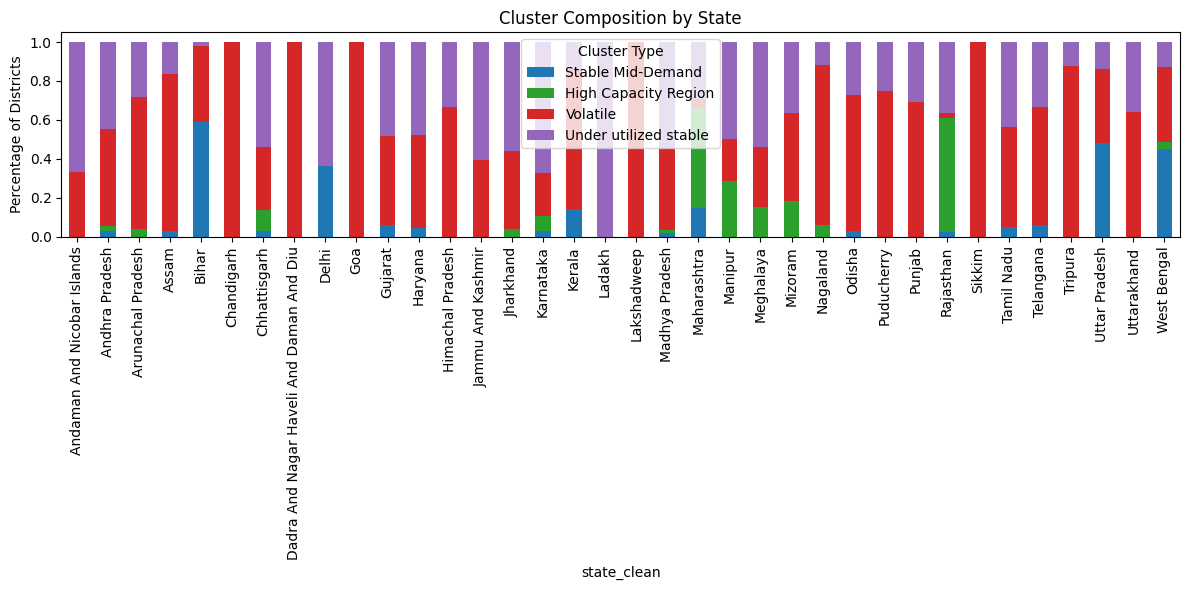

In [39]:
state_cluster_distribution = (
    INPUT.reset_index()
    .groupby(['state_clean','cluster_kmeans'])
    .size()
    .reset_index(name='count')
)

pivot = state_cluster_distribution.pivot(
    index='state_clean',
    columns='cluster_kmeans',
    values='count'
).fillna(0)


state_pct = pivot.div(pivot.sum(axis=1),axis=0)


state_pct.plot(kind='bar',stacked=True,figsize=(12,6),color=[CLUSTER_COLORS[c] for c in pivot.columns])

plt.legend([CLUSTER_NAMES[c] for c in pivot.columns], title="Cluster Type")
plt.title("Cluster Composition by State")
plt.ylabel("Percentage of Districts")
plt.tight_layout()
plt.show()

In [40]:
df_copy["month"].min(),df_copy["month"].max()

(3, 12)

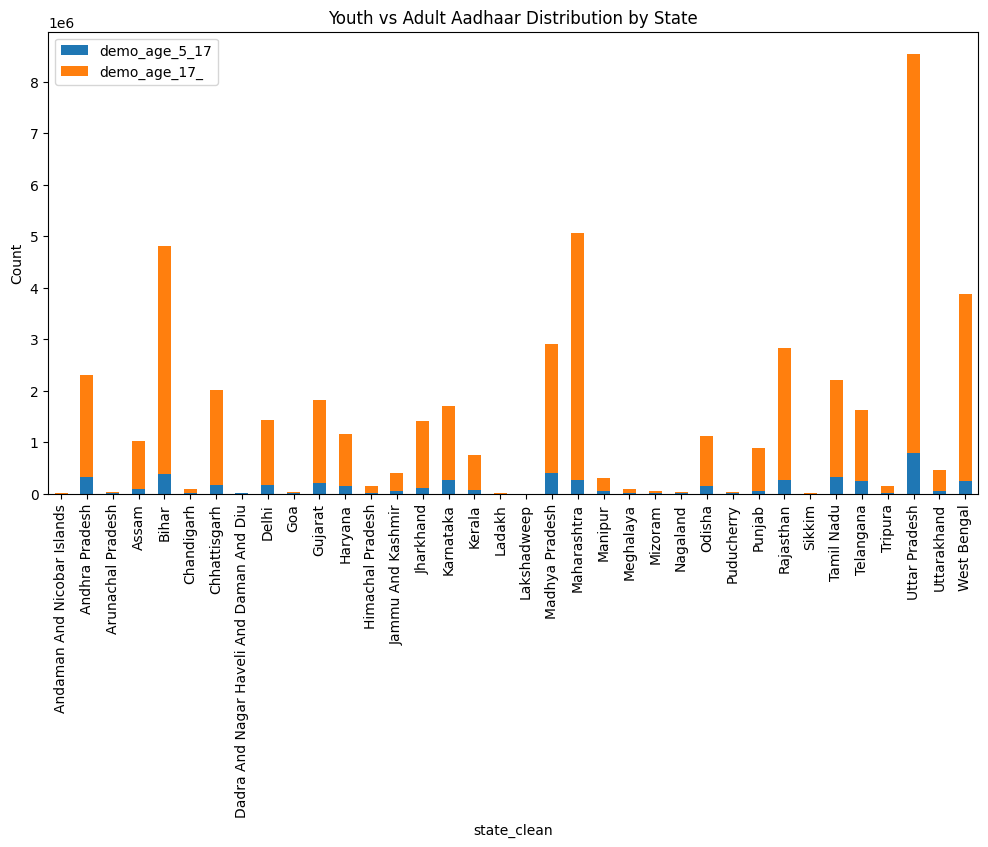

In [41]:
age_state = df_copy.groupby("state_clean")[["demo_age_5_17","demo_age_17_"]].sum()

age_state.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Youth vs Adult Aadhaar Distribution by State")
plt.ylabel("Count")
plt.show()


*Smaller and geographically isolated regions exhibit lower Aadhaar volumes due to reduced population size and logistical constraints.*

In [42]:
age_month = df_copy.groupby("month")[["demo_age_5_17", "demo_age_17_"]].sum()


In [43]:
ratio_state = df_copy.groupby("state_clean")["youth_ratio"].mean().sort_values(ascending=False)
ratio_state.head(10)


state_clean
Manipur              0.152876
Ladakh               0.141605
Arunachal Pradesh    0.133022
Tamil Nadu           0.131173
Telangana            0.128285
Andhra Pradesh       0.115906
Madhya Pradesh       0.110715
Odisha               0.105682
Rajasthan            0.100109
Jammu And Kashmir    0.099470
Name: youth_ratio, dtype: float64

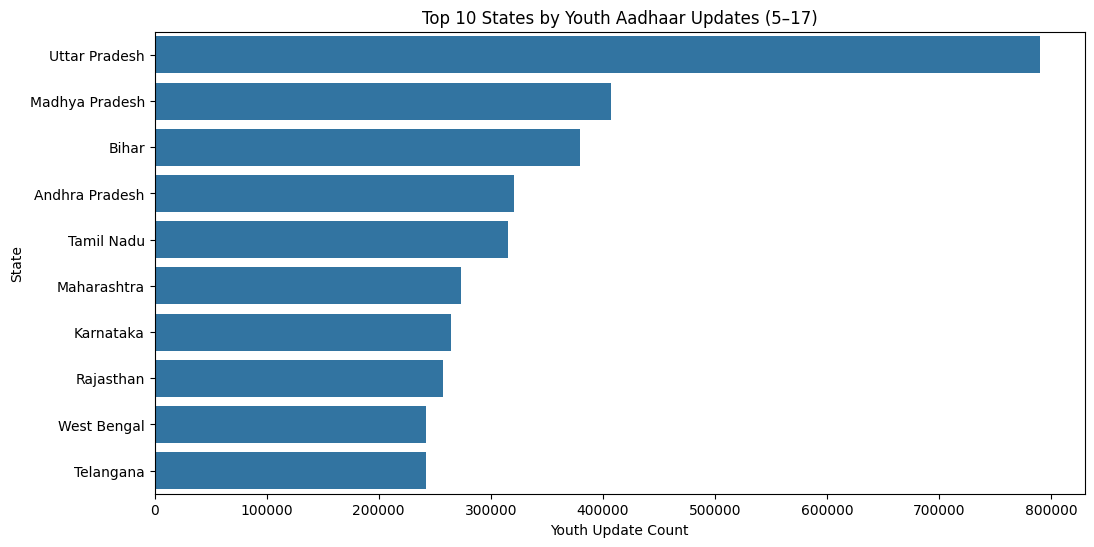

In [44]:
youth_state = df_copy.groupby("state_clean")["demo_age_5_17"].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=youth_state.values[:10], y=youth_state.index[:10])
plt.title("Top 10 States by Youth Aadhaar Updates (5–17)")
plt.xlabel("Youth Update Count")
plt.ylabel("State")
plt.show()


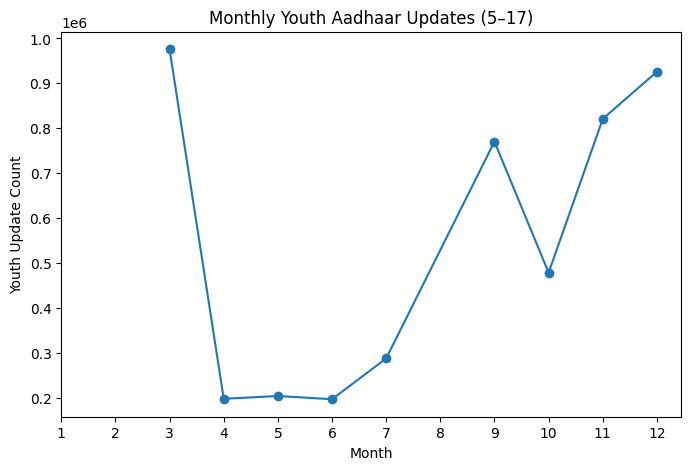

In [45]:
youth_month = df_copy.groupby("month")["demo_age_5_17"].sum()

plt.figure(figsize=(8,5))
plt.plot(youth_month.index, youth_month.values, marker='o')
plt.title("Monthly Youth Aadhaar Updates (5–17)")
plt.xlabel("Month")
plt.ylabel("Youth Update Count")
plt.xticks(range(1,13))
plt.show()


**The highest number of Aadhaar updates for the 5–17 age group occurred in March.**

This could be due to:

1.School admissions

2.Address updates

3.Age-based biometric updates

4.Academic year transitions

**Sharp drop in April-June**
From April to June, updates fall drastically

This suggests:

1.Fewer administrative requirements for children

2.Post-admission period

3.Lower demand for updates

4.Gradual Rise from July to September

**Updates increase again, peaking in September**

This may reflect:

1.Mid-year relocations

2.School transfers

3.Document corrections

**October shows a noticeable dip.**

Likely due to:

1.Festival season

2.Reduced government office activity

**Strong Rise in November–December**

Updates rise again, reaching another high in December

Possible reasons:

1.Year-end administrative updates

2.Address changes

3.Document corrections before the new year

<Axes: xlabel='cluster'>

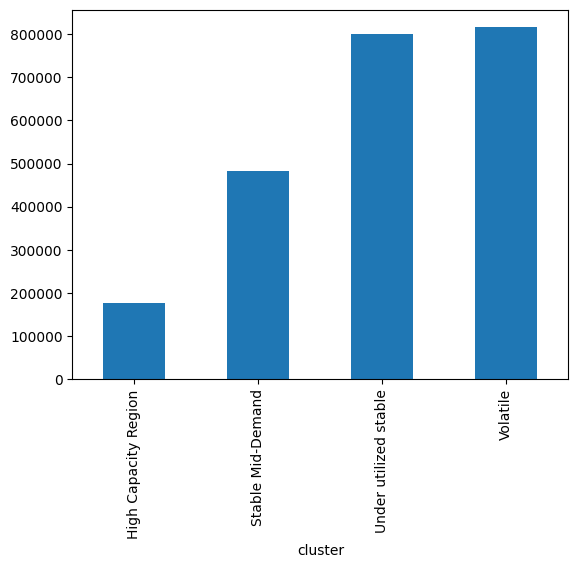

In [46]:
df_clustered = pd.merge(left=df_copy,right=INPUT,how='left',on = 'district_clean')[df_copy.columns.tolist()+['cluster_kmeans']]
df_clustered['cluster'] = df_clustered['cluster_kmeans'].map(CLUSTER_NAMES)
df_clustered.groupby(['cluster']).size().sort_values().plot(kind='bar')

In [47]:
df_copy['month'] = df_copy['date'].dt.to_period('M')

monthly_dates = (
    df_copy.groupby('month')['date']
      .apply(lambda x: sorted(x.dt.date.unique()))
)

monthly_dates


month
2025-03                                         [2025-03-01]
2025-04                                         [2025-04-01]
2025-05                                         [2025-05-01]
2025-06                                         [2025-06-01]
2025-07                                         [2025-07-01]
2025-09    [2025-09-01, 2025-09-02, 2025-09-03, 2025-09-0...
2025-10    [2025-10-13, 2025-10-15, 2025-10-16, 2025-10-1...
2025-11    [2025-11-01, 2025-11-02, 2025-11-03, 2025-11-0...
2025-12    [2025-12-01, 2025-12-02, 2025-12-03, 2025-12-0...
Freq: M, Name: date, dtype: object

In [48]:
monthly_day_count = (
    df_copy.groupby(df_copy['date'].dt.to_period('M'))['date']
      .nunique()
)

monthly_day_count


date
2025-03     1
2025-04     1
2025-05     1
2025-06     1
2025-07     1
2025-09    20
2025-10    18
2025-11    24
2025-12    28
Freq: M, Name: date, dtype: int64

In [49]:
august_dates = (
    df_copy[df_copy['date'].dt.month == 8]['date']
      .dt.date
      .unique()
)

sorted(august_dates)


[]

In [50]:
monthly_ts = (
    df_copy.groupby('month')['total_demo']
      .sum()
)

monthly_ts


month
2025-03    11141194
2025-04     1515672
2025-05     1566287
2025-06     1685562
2025-07     2220715
2025-09     7318760
2025-10     5008457
2025-11     9382254
2025-12     9430849
Freq: M, Name: total_demo, dtype: int64

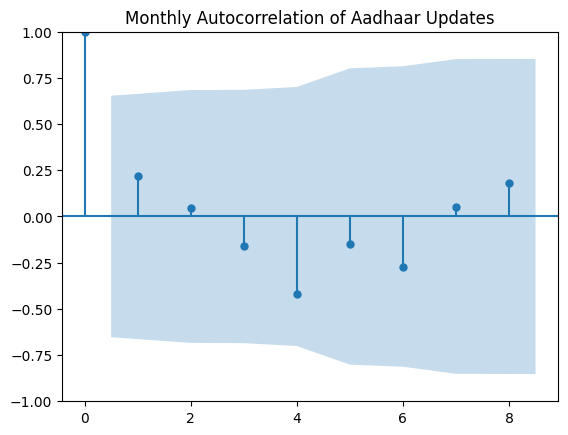

In [51]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(monthly_ts, lags=8)
plt.title("Monthly Autocorrelation of Aadhaar Updates")
plt.show()


In [52]:
# Total registrations per district
district_total = (
    df_copy.groupby('district_clean')['total_demo']
    .sum()
    .reset_index(name='district_total')
)

# Pincode-wise registrations per district
pincode_stats = (
    df_copy.groupby(['district_clean','pincode'])['total_demo']
    .sum()
    .reset_index(name='pincode_total')
)

# Merge totals
pincode_stats = pincode_stats.merge(district_total, on='district_clean')

# Share of each pincode in its district
pincode_stats['share'] = (
    pincode_stats['pincode_total'] / pincode_stats['district_total']
)


In [53]:
# Sort pincodes by contribution
pincode_sorted = pincode_stats.sort_values(
    ['district_clean','share'], ascending=[True, False]
)

# Take top 2 pincodes per district
top2 = (
    pincode_sorted.groupby('district_clean')
    .head(2)
)

# Sum their shares
top2_share = (
    top2.groupby('district_clean')['share']
    .sum()
    .reset_index(name='top2_share')
)

# Districts where top 2 ≥ 80%
high_concentration = top2_share[top2_share['top2_share'] >= 0.80]

high_concentration


,district_clean,top2_share
28,Anjaw,1.000000
50,Balianta,1.000000
58,Bandipore,0.875433
90,Bhadrak R,1.000000
101,Bicholim,1.000000
...,...,...
788,West Khasi Hills,0.997629
791,West Siang,0.847128
795,Wokha,0.995276
800,Yanam,1.000000


In [54]:
overloaded_pincodes = top2.merge(
    high_concentration[['district_clean']],
    on='district_clean'
)

overloaded_pincodes


,district_clean,pincode,pincode_total,district_total,share
0,Anjaw,792104,760,760,1.000000
1,Balianta,752101,1,1,1.000000
2,Bandipore,193502,11179,15895,0.703303
3,Bandipore,193501,2736,15895,0.172130
4,Bhadrak R,756113,1,1,1.000000
...,...,...,...,...,...
131,Wokha,797111,1807,1905,0.948556
132,Wokha,797100,89,1905,0.046719
133,Yanam,533464,313,313,1.000000
134,Zunheboto,798620,2064,2439,0.846248


## 11. Priority districts to act on for volatility check 
- we define a custom risk_score based on mean, volatility and range_ratio

$PriorityScore = 0.4*Volatility + 0.4*RangeRatio + 0.2*(1-MeanVolume) $

In [56]:
stats

mean  \
state_clean                 district_clean                           
Andaman And Nicobar Islands Nicobar                     157.400000   
                            North and Middle Andaman    334.833333   
                            South Andaman               739.200000   
Andhra Pradesh              Adilabad                   5858.200000   
                            Alluri Sitharama Raju      2145.166667   
...                                                            ...   
West Bengal                 South 24 Pargana              9.666667   
                            South 24 Parganas         49252.333333   
                            South Dinajpur             1704.750000   
                            Uttar Dinajpur            30025.777778   
                            West Midnapore             7673.000000   

                                                               std    min  \
state_clean                 district_clean                                  
Andaman And Nicobar Islands Nicobar                     135.828200     59   
                            North and Middle Andaman    118.658193    149   
                            South Andaman               408.456485    398   
Andhra Pradesh              Adilabad                   1314.437789   4340   
                            Alluri Sitharama Raju      1584.877461    167   
...                                                            ...    ...   
West Bengal                 South 24 Pargana              3.785939      7   
                            South 24 Parganas         32051.823474   7791   
                            South Dinajpur              486.210774   1158   
                            Uttar Dinajpur            14402.573223  10085   
                            West Midnapore             2463.884061   5645   

                                                        max  volatility  \
state_clean                 district_clean                                
Andaman And Nicobar Islands Nicobar                     392    0.857501   
                            North and Middle Andaman    438    0.353325   
                            South Andaman              1371    0.551819   
Andhra Pradesh              Adilabad                   7291    0.224337   
                            Alluri Sitharama Raju      4955    0.738469   
...                                                     ...         ...   
West Bengal                 South 24 Pargana             14    0.354932   
                            South 24 Parganas         99976    0.650754   
                            South Dinajpur             2121    0.285042   
                            Uttar Dinajpur            50943    0.479658   
                            West Midnapore            11195    0.321069   

                                                      range_ratio  \
state_clean                 district_clean                          
Andaman And Nicobar Islands Nicobar                      2.102273   
                            North and Middle Andaman     0.860546   
                            South Andaman                1.314510   
Andhra Pradesh              Adilabad                     0.503652   
                            Alluri Sitharama Raju        2.230954   
...                                                           ...   
West Bengal                 South 24 Pargana             0.656250   
                            South 24 Parganas            1.871650   
                            South Dinajpur               0.564561   
                            Uttar Dinajpur               1.360719   
                            West Midnapore               0.723221   

                                                      cluster_kmeans  \
state_clean                 district_clean                             
Andaman And Nicobar Islands Nicobar                                3   
                            North and Middle Andaman       

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

stats[['vol_n','range_n','mean_n']] = scaler.fit_transform(
    stats[['volatility','range_ratio','mean']]
)

stats['priority_score'] = 0.4*stats['vol_n'] + 0.4*stats['range_n'] + 0.2*(1-stats['mean_n'])

stats.head()

mean  \
state_clean                 district_clean                          
Andaman And Nicobar Islands Nicobar                    157.400000   
                            North and Middle Andaman   334.833333   
                            South Andaman              739.200000   
Andhra Pradesh              Adilabad                  5858.200000   
                            Alluri Sitharama Raju     2145.166667   

                                                              std   min   max  \
state_clean                 district_clean                                      
Andaman And Nicobar Islands Nicobar                    135.828200    59   392   
                            North and Middle Andaman   118.658193   149   438   
                            South Andaman              408.456485   398  1371   
Andhra Pradesh              Adilabad                  1314.437789  4340  7291   
                            Alluri Sitharama Raju     1584.877461   167  4955   

                                                      volatility  range_ratio  \
state_clean                 district_clean                                      
Andaman And Nicobar Islands Nicobar                     0.857501     2.102273   
                            North and Middle Andaman    0.353325     0.860546   
                            South Andaman               0.551819     1.314510   
Andhra Pradesh              Adilabad                    0.224337     0.503652   
                            Alluri Sitharama Raju       0.738469     2.230954   

                                                      cluster_kmeans  \
state_clean                 district_clean                             
Andaman And Nicobar Islands Nicobar                                3   
                            North and Middle Andaman               2   
                            South Andaman                          3   
Andhra Pradesh              Adilabad                               2   
                            Alluri Sitharama Raju                  3   

                                                      cluster_dbscan  \
state_clean                 district_clean                             
Andaman And Nicobar Islands Nicobar                                0   
                            North and Middle Andaman               0   
                            South Andaman                          0   
Andhra Pradesh              Adilabad                               0   
                            Alluri Sitharama Raju                  0   

                                                         vol_n   range_n  \
state_clean                 district_clean                                 
Andaman And Nicobar Islands Nicobar                   0.590764  0.453598   
                            North and Middle Andaman  0.243418  0.185676   
                            South Andaman             0.380169  0.283626   
Andhra Pradesh              Adilabad                  0.154554  0.108671   
                            Alluri Sitharama Raju     0.508759  0.481363   

                                                        mean_n  priority_score  
state_clean                 district_clean                                      
Andaman And Nicobar Islands Nicobar                   0.003147        0.617116  
                            North and Middle Andaman  0.006718        0.370294  
                            South Andaman             0.014855        0.462547  
Andhra Pradesh              Adilabad                  0.117866        0.281717  
                            Alluri Sitharama Raju     0.043147        0.587419

In [58]:
stats.reset_index()

,state_clean,district_clean,mean,std,min,max,volatility,range_ratio,cluster_kmeans,cluster_dbscan,vol_n,range_n,mean_n,priority_score
0,Andaman And Nicobar Islands,Nicobar,157.400000,135.828200,59,392,0.857501,2.102273,3,0,0.590764,0.453598,0.003147,0.617116
1,Andaman And Nicobar Islands,North and Middle Andaman,334.833333,118.658193,149,438,0.353325,0.860546,2,0,0.243418,0.185676,0.006718,0.370294
2,Andaman And Nicobar Islands,South Andaman,739.200000,408.456485,398,1371,0.551819,1.314510,3,0,0.380169,0.283626,0.014855,0.462547
3,Andhra Pradesh,Adilabad,5858.200000,1314.437789,4340,7291,0.224337,0.503652,2,0,0.154554,0.108671,0.117866,0.281717
4,Andhra Pradesh,Alluri Sitharama Raju,2145.166667,1584.877461,167,4955,0.738469,2.230954,3,0,0.508759,0.481363,0.043147,0.587419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,West Bengal,South 24 Pargana,9.666667,3.785939,7,14,0.354932,0.656250,2,0,0.244526,0.141596,0.000174,0.354414
837,West Bengal,South 24 Parganas,49252.333333,32051.823474,7791,99976,0.650754,1.871650,0,-1,0.448329,0.403838,0.991094,0.342648
838,West Bengal,South Dinajpur,1704.750000,486.210774,1158,2121,0.285042,0.564561,2,0,0.196376,0.121813,0.034285,0.320419
839,West Bengal,Uttar Dinajpur,30025.777778,14402.573223,10085,50943,0.479658,1.360719,0,0,0.330454,0.293596,0.604195,0.328781


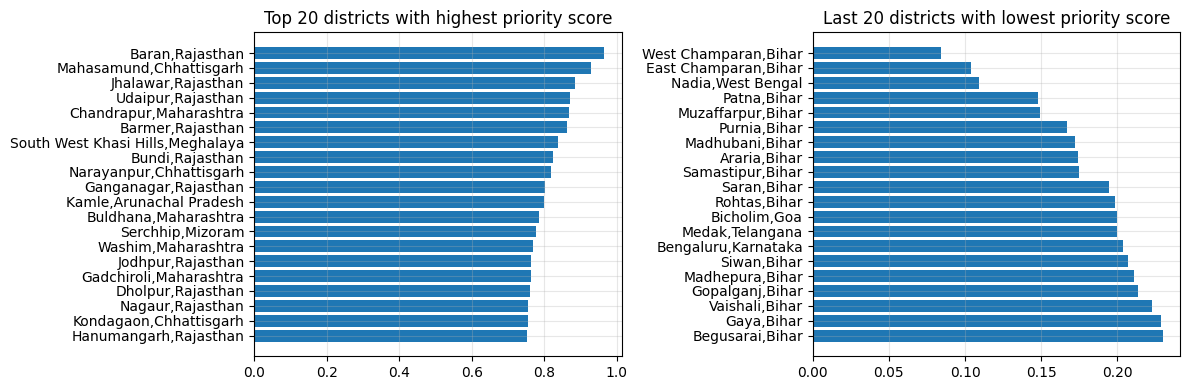

In [59]:
priority_districts_desc = (
    stats.reset_index().sort_values(by='priority_score',ascending=False)
    [['state_clean','district_clean','cluster_kmeans','priority_score']]
    .head(20)
)

priority_districts_asc = (
    stats.reset_index().sort_values(by='priority_score',ascending=True)
    [['state_clean','district_clean','cluster_kmeans','priority_score']]
    .head(20)
)

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].barh(y = priority_districts_desc.apply(lambda row: row['district_clean']+","+row['state_clean'],axis=1),width=priority_districts_desc['priority_score'])
ax[0].set_title('Top 20 districts with highest priority score')
ax[0].grid(alpha=0.3)
ax[0].invert_yaxis()

ax[1].barh(y = priority_districts_asc.apply(lambda row: row['district_clean']+","+row['state_clean'],axis=1),width=priority_districts_asc['priority_score'])
ax[1].set_title('Last 20 districts with lowest priority score')
ax[1].grid(alpha=0.3)
ax[1].invert_yaxis()

plt.tight_layout()

## 12. State Operational based on volatile cluster counts

In [60]:
state_burden = (
    stats.groupby('state_clean')
    .agg(
        avg_risk = ('priority_score','mean'),
        volatile_share = ('cluster_kmeans',lambda x: (x==2).mean()),
        under_utilized_share = ('cluster_kmeans',lambda x: (x==3).mean())
    ).reset_index()
)

state_burden = state_burden.sort_values(by = 'avg_risk',ascending=False)

In [61]:
y_labels = state_burden.state_clean.values[:15]
width = state_burden.avg_risk.values[:15]
volatile_pct = state_burden.volatile_share.values[:15]

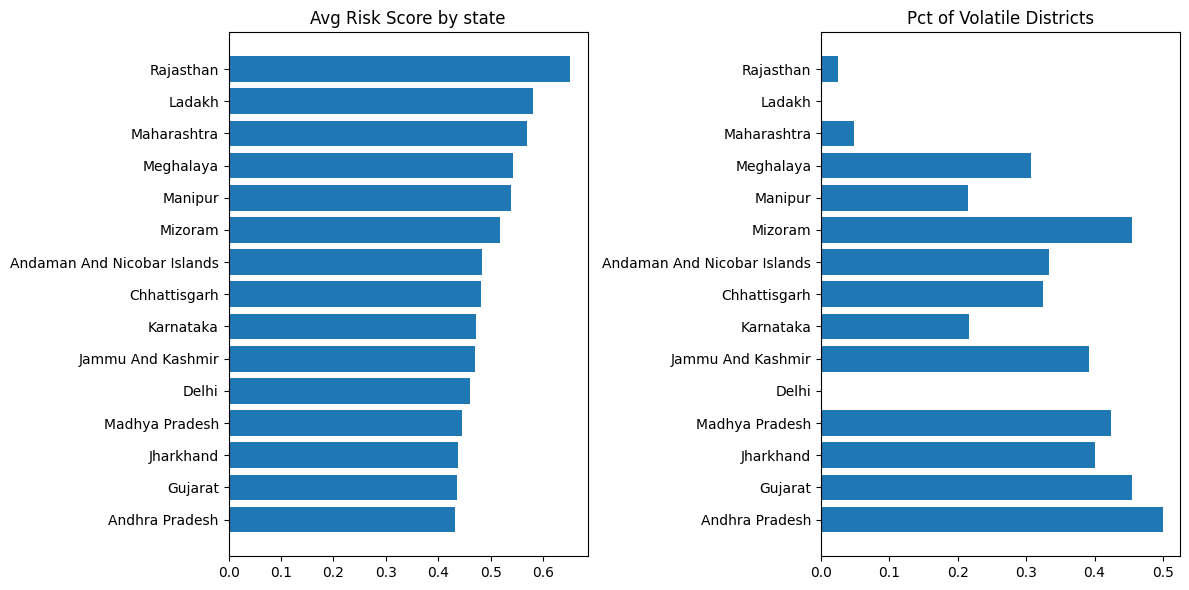

In [62]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].barh(y=y_labels,width = width)
ax[0].invert_yaxis()
ax[0].set_title('Avg Risk Score by state')


ax[1].barh(y=y_labels,width = volatile_pct)
ax[1].invert_yaxis()
ax[1].set_title('Pct of Volatile Districts')
plt.tight_layout()